In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the data 

Simulation parameters (all of them, but they should be cleaned) and simulation outputs.

In [1]:
def get_features_and_outputs_from_simulations(output_name, timestamp):
    """
    Reads the simulation parameter map, fetches Cassandra to obtain the correspoding output for the specified timestamp.
    Splits the data into train/test sets with, returns c3.Dataset for each one of them.
    
    
    Inputs:
    - str output_name: name of the variable in SimulationModelOutput under investigation
    - str timestamp: shape of the timestamp to fetch the timeseries, e.g. "2017-08-19T09:00:00.000"
    
    Returns:
    - c3.Dataset X_train: train set of features
    - c3.Dataset X_test: test set of features
    - c3.Dataset y_train: train set of outputs
    - c3.Dataset y_test: test set of outputs

    """
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    # fetch simulation parameters
    parameters = c3.SimulationModelParameters.fetch().objs
    parameters = parameters.toJson()
    df = pd.DataFrame(parameters)
    simulations = pd.DataFrame(df['id'])
    X = df[df.columns[5:]]
    
    # define simple metric
    metric_name = "Average_" + output_name + "_SimulationSample" 
    metric_descr = "Calculates average of " + output_name + " for a given set of SimulationSample"
    metric_expr = "avg(avg(normalized.data." + output_name + "))"
    metric = c3.SimpleMetric(id = metric_name,
                                    name = metric_name,
                                    description = metric_descr,
                                    srcType = "SimulationSample",
                                    path = "output",  # the timeseries is in the output field of SimSam
                                    expression = metric_expr
                                  )
    
    # define metric spec
    spec = c3.EvalMetricsSpec(
                                    ids = simulations['id'],
                                    expressions = [metric_name],
                                    start = timestamp,
                                    end = timestamp,
                                    interval = "SECOND" 
                                )

    # evaluate metric, cast it to pandas
    evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                                        spec=spec,
                                                                        overrideMetrics=[metric]
                                                                    )
    y = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)
    
    
    # split into train/test sets
    datasets = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # cast into c3 Datasets
    X_train = c3.Dataset.fromPython(datasets[0])
    X_test = c3.Dataset.fromPython(datasets[1])
    y_train = c3.Dataset.fromPython(datasets[2])
    y_test = c3.Dataset.fromPython(datasets[3])
    
    return X_train, X_test, y_train, y_test

In [2]:
X_train, X_test, y_train, y_test = get_features_and_outputs_from_simulations("mass_BC_acc", "2017-08-19T09:00:00.000")

# 2. Build initial pipeline

For this initial search, we are not going to do PCA. We will also start with a constant kernel.

In [13]:
# single pipe is GP Regression
GPR_kernel = c3.SklearnGPRKernelConstant(constantValue=1.0).build().kernel

gp_reg = c3.MLStep(
    name="GPR",
    pipe=c3.GaussianProcessRegressionPipe(
        technique=c3.GaussianProcessRegressionTechnique(
            randomState=42,
            kernel=GPR_kernel
        )
    )
)

# pipe becomes pipeline
pipeline = c3.MLSerialPipeline(
    steps=[
        gp_reg
    ],
    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLRSquaredMetric()])
)

In [14]:
pipeline.hyperParams()

c3.Mapp<string, any>({'GPR__kernel': c3.SklearnGPRKernel(
                 name='Constant',
                 hyperParameters=c3.Arry<double>([1.0]),
                 pickledKernel='eJxrYEouzs5JTSzK00tPLC0uzkzMiy8oyk9OLS7Wy04tykvNKeZyzs8rLknMK/EG87kKGTQbCxlrC5k0IvgYGBiSobLxZYk5pamFzO72HxjAIEIUQzY+Kb80L6W4kMXd7smPrR2PMz66O/zIAqtuK2QtTdIDACemMe8='),
 'GPR__randomState': 42.0})

# 3. Substitute kernel

Let's say we want to change from Constant to DotProduct.

In [15]:
# create new kernel
new_kernel = c3.SklearnGPRKernelDotProduct(sigmaZero=1.0).build().kernel

pipeline = pipeline.withHyperParams({
        "GPR__kernel": new_kernel
    })

In [16]:
pipeline.hyperParams()

c3.Mapp<string, any>({'GPR__kernel': c3.SklearnGPRKernel(
                 name='DotProduct',
                 hyperParameters=c3.Arry<double>([1.0]),
                 pickledKernel='eJxrYEouzs5JTSzK00tPLC0uzkzMiy8oyk9OLS7Wy04tykvNKeZyyS8JKMpPKU0u4Spk0GwsZKwtZNKIYGdgYCjOTM9NjDcoZHa3/8AABhF8COH4pPzSvJTiQhZ3uyc/tnY8zvjo7vAjC6ysrZC1NEkPAHq8KbI='),
 'GPR__randomState': 42.0})

That seems to have worked alright. Now we need to iterate over all kernels and then iterate over each one of the parameters.

# 4. Iterate over different kernels

## a) Constant kernel

Obviously there is not much that can be done with the constant kernel, bur for demonstration purposes we will do this.

In [19]:
help(c3.SklearnGPRKernelConstant)

So the parameter to iterate over here is `constantValue`.

In [34]:
constant_kernel_scores = []

dr = 1.0
for i in range(1,11):
    
    const_val = i*dr
    
    # create new kernel
    new_kernel = c3.SklearnGPRKernelConstant(constantValue=const_val).build().kernel
    
    # impute to pipeline
    pipeline = pipeline.withHyperParams({
        "GPR__kernel": new_kernel
    })
    
    # train
    trained_pipeline = pipeline.train(input=X_train, targetOutput=y_train)
    
    # score over test set
    score = trained_pipeline.score(input=X_test, targetOutput=y_test)
    print('Constant Kernel constantValue: ', const_val, '  Score on test:', score['MLRSquaredMetric'])
    p_score = [const_val, score['MLRSquaredMetric']]
    constant_kernel_scores.append(p_score)

Constant Kernel constantValue:  1.0   Score on test: -0.1648442689414411
Constant Kernel constantValue:  2.0   Score on test: -0.16484426837406985
Constant Kernel constantValue:  3.0   Score on test: -0.16484426837406985
Constant Kernel constantValue:  4.0   Score on test: -0.16484426837406985
Constant Kernel constantValue:  5.0   Score on test: -0.16484426837406985
Constant Kernel constantValue:  6.0   Score on test: -0.1648442689414411
Constant Kernel constantValue:  7.0   Score on test: -0.16484426837406985
Constant Kernel constantValue:  8.0   Score on test: -0.1648442689414411
Constant Kernel constantValue:  9.0   Score on test: -0.16484427003966484
Constant Kernel constantValue:  10.0   Score on test: -0.16484426871760305


In [35]:
constant_kernel_scores = np.array(constant_kernel_scores)

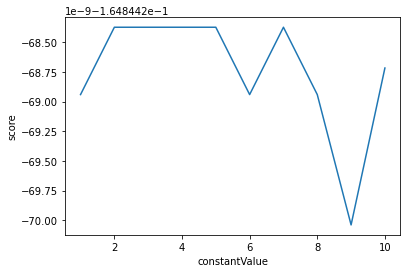

In [38]:
plt.figure()
plt.plot(constant_kernel_scores[:,0], constant_kernel_scores[:,1])
plt.xlabel('constantValue');
plt.ylabel('score');

## b) Dot Product kernel

In [33]:
help(c3.SklearnGPRKernelDotProduct)

`sigmaZero` is the single hyper parameter here.

In [40]:
dotproduct_kernel_scores = []

dr = 1.0
for i in range(1,11):
    
    sigmaZero = i*dr
    
    # create new kernel
    new_kernel = c3.SklearnGPRKernelDotProduct(sigmaZero=sigmaZero).build().kernel
    
    # impute to pipeline
    pipeline = pipeline.withHyperParams({
        "GPR__kernel": new_kernel
    })
    
    # train
    trained_pipeline = pipeline.train(input=X_train, targetOutput=y_train)
    
    # score over test set
    score = trained_pipeline.score(input=X_test, targetOutput=y_test)
    print('Dot Product Kernel constantValue: ', sigmaZero, '  Score on test:', score['MLRSquaredMetric'])
    p_score = [sigmaZero, score['MLRSquaredMetric']]
    dotproduct_kernel_scores.append(p_score)

Dot Product Kernel constantValue:  1.0   Score on test: 0.6538924455350434
Dot Product Kernel constantValue:  2.0   Score on test: 0.6536451257104016
Dot Product Kernel constantValue:  3.0   Score on test: 0.6537085506875755
Dot Product Kernel constantValue:  4.0   Score on test: 0.6536961650161988
Dot Product Kernel constantValue:  5.0   Score on test: 0.6538592789170065
Dot Product Kernel constantValue:  6.0   Score on test: 0.6536946842692002
Dot Product Kernel constantValue:  7.0   Score on test: 0.6537638415141427
Dot Product Kernel constantValue:  8.0   Score on test: 0.653789979598252
Dot Product Kernel constantValue:  9.0   Score on test: 0.6537900266114735
Dot Product Kernel constantValue:  10.0   Score on test: 0.6537536511188214


In [42]:
dotproduct_kernel_scores = np.array(dotproduct_kernel_scores)

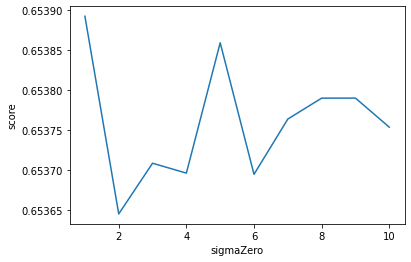

In [44]:
plt.figure()
plt.plot(dotproduct_kernel_scores[:,0], dotproduct_kernel_scores[:,1])
plt.xlabel('sigmaZero');
plt.ylabel('score');

## c) ExpSineSquared kernel

In [45]:
help(c3.SklearnGPRKernelExpSineSquared)

This one has two parameters: `lengthScale` and `peridicity`

In [47]:
expsinesquared_kernel_scores = []

dr = 1.0
dp = 1.0
for i in range(1,11):
    lengthScale = i*dr
    
    per_scores = []
    for j in range(1,5):
        
        periodicity = j*dp
    
        # create new kernel
        new_kernel = c3.SklearnGPRKernelExpSineSquared(lengthScale=lengthScale, periodicity=periodicity).build().kernel
    
        # impute to pipeline
        pipeline = pipeline.withHyperParams({
            "GPR__kernel": new_kernel
        })
    
        # train
        trained_pipeline = pipeline.train(input=X_train, targetOutput=y_train)
    
        # score over test set
        score = trained_pipeline.score(input=X_test, targetOutput=y_test)
        print('ExpSineSquared Kernel lengthScale: ', lengthScale, ', periodicity: ', periodicity, '  Score on test:', score['MLRSquaredMetric'])
        p_score = [sigmaZero, score['MLRSquaredMetric']]
        per_scores.append(p_score)
        
    expsinesquared_kernel_scores.append(per_scores)

500 - NotClassified - c3.love.util.OsUtil_err2 [8662.2759]
message: "Error executing command: /usr/local/share/c3/condaEnvs/dev/tc02d/py-gordon-ML_1_0_0/bin/python /tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py
Process exited with 3 exit code.
a_id=8555.24664440 a_implementation=python t_tenant=dev t_tag=tc02d t_type=GaussianProcessRegressionPipe t_action=train p_logger=action url=http://dev-dti-app-m-04:8080 connector=null mode="thick" Action failed!
Traceback (most recent call last):
  File "/tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py", line 406, in _c3_remote_bootstrap__run_c3_action
    _c3_result = _action()
  File "/tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py", line 535, in <lambda>
    action=lambda: train(this = _c3_inputs.get('this'),input = _c3_inputs.get('input'),targetOutput = _c3_inputs.get('targetOutput'),spec = _c3_inputs.get('spec')),
  File "Gaus

C3RuntimeException: 500 - NotClassified - c3.love.util.OsUtil_err2 [8662.2759]
message: "Error executing command: /usr/local/share/c3/condaEnvs/dev/tc02d/py-gordon-ML_1_0_0/bin/python /tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py
Process exited with 3 exit code.
a_id=8555.24664440 a_implementation=python t_tenant=dev t_tag=tc02d t_type=GaussianProcessRegressionPipe t_action=train p_logger=action url=http://dev-dti-app-m-04:8080 connector=null mode="thick" Action failed!
Traceback (most recent call last):
  File "/tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py", line 406, in _c3_remote_bootstrap__run_c3_action
    _c3_result = _action()
  File "/tmp/pythonActionSourceCache2109218811953179188/GaussianProcessRegressionPipe_train.py", line 535, in <lambda>
    action=lambda: train(this = _c3_inputs.get('this'),input = _c3_inputs.get('input'),targetOutput = _c3_inputs.get('targetOutput'),spec = _c3_inputs.get('spec')),
  File "GaussianProcessRegressionPipe.py", line 17, in train
    gp.fit(X, y)
  File "/usr/local/share/c3/condaEnvs/dev/tc02d/py-gordon-ML_1_0_0/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py", line 265, in fit
    self.L_ = cholesky(K, lower=True)  # Line 2
  File "/usr/local/share/c3/condaEnvs/dev/tc02d/py-gordon-ML_1_0_0/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/usr/local/share/c3/condaEnvs/dev/tc02d/py-gordon-ML_1_0_0/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 40, in _cholesky
    "definite" % info)
numpy.linalg.LinAlgError: ("The kernel, ExpSineSquared(length_scale=1, periodicity=1), is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '3-th leading minor of the array is not positive definite')"
JSON: {"this": {"type": "MLSerialPipeline", "noTrainScore": false, "scoringMetrics": {"MLRSquaredMetric": {"type": "MLRSquaredMetric"}}, "untrainableOverride": false, "steps": [{"type": "MLStep", "name": "GPR", "pipe": {"type": "GaussianProcessRegressionPipe", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "GaussianProcessRegressionTechnique", "randomState": 42, "kernel": {"type": "SklearnGPRKernel", "name": "ExpSineSquared", "hyperParameters": [1.0, 1.0], "pickledKernel": "eJxrYEouzs5JTSzK00tPLC0uzkzMiy8oyk9OLS7Wy04tykvNKeZyrSgIzsxLDS4sTSxKTeEqZNBsLGSsLWTSiOBhYGDISc1LL8mIL05OzEktZHa3/8AABhHcQKIgtSgzPyUzObOkspAFISWMpi0+Kb80L6W4kNXd7smPrR2PMz66O/zIAqttK2SLEEI1CaaaPYOtNEkPAFUMP6s="}}}}]}, "input": {"type": "Dataset", "shape": [198, 59], "indices": {"0": ["25", "127", "201", "97", "16", "45", "154", "111", "55", "108", "196", "73", "109", "82", "138", "141", "101", "86", "193", "120", "95", "79", "218", "113", "140", "122", "162", "216", "38", "24", "185", "137", "29", "19", "69", "205", "60", "68", "5", "139", "56", "156", "176", "163", "65", "112", "186", "155", "31", "12", "35", "28", "42", "84", "104", "150", "51", "124", "177", "76", "41", "135", "78", "178", "26", "146", "173", "206", "0", "2", "77", "46", "153", "118", "90", "85", "147", "98", "36", "125", "61", "22", "144", "117", "33", "11", "215", "183", "6", "27", "136", "212", "203", "4", "32", "119", "159", "126", "158", "114", "10", "62", "164", "194", "181", "128", "198", "167", "70", "170", "64", "44", "143", "40", "123", "23", "165", "161", "81", "39", "184", "47", "94", "168", "43", "145", "152", "3", "105", "53", "133", "199", "171", "204", "49", "80", "34", "7", "110", "91", "83", "195", "200", "89", "8", "13", "59", "214", "131", "17", "166", "72", "192", "134", "182", "208", "63", "54", "107", "50", "174", "217", "169", "58", "48", "88", "21", "57", "160", "213", "187", "191", "129", "37", "157", "207", "1", "52", "149", "130", "151", "103", "99", "116", "87", "202", "74", "210", "121", "220", "20", "188", "71", "106", "14", "92", "179", "102"], "1": ["acure_bl_nuc", "acure_ait_width", "acure_cloud_ph", "acure_carb_ff_ems", "acure_carb_ff_ems_eur", "acure_carb_ff_ems_nam", "acure_carb_ff_ems_chi", "acure_carb_ff_ems_asi", "acure_carb_ff_ems_mar", "acure_carb_ff_ems_r", "acure_carb_bb_ems", "acure_carb_bb_ems_sam", "acure_carb_bb_ems_naf", "acure_carb_bb_ems_saf", "acure_carb_bb_ems_bnh", "acure_carb_bb_ems_rnh", "acure_carb_bb_ems_rsh", "acure_carb_res_ems", "acure_carb_res_ems_chi", "acure_carb_res_ems_asi", "acure_carb_res_ems_afr", "acure_carb_res_ems_lat", "acure_carb_res_ems_r", "acure_carb_ff_diam", "acure_carb_bb_diam", "acure_carb_res_diam", "acure_prim_so4_diam", "acure_sea_spray", "acure_anth_so2", "acure_anth_so2_chi", "acure_anth_so2_asi", "acure_anth_so2_eur", "acure_anth_so2_nam", "acure_anth_so2_r", "acure_volc_so2", "acure_bvoc_soa", "acure_dms", "acure_prim_moc", "acure_dry_dep_ait", "acure_dry_dep_acc", "acure_dry_dep_so2", "acure_kappa_oc", "acure_sig_w", "acure_rain_frac", "acure_cloud_ice_thresh", "acure_convective_plume_scavenging", "acure_scav_diam", "acure_bc_ri", "acure_oxidants_oh", "acure_oxidants_o3", "bparam", "two_d_fsd_factor", "c_r_correl", "acure_autoconv_exp_lwp", "acure_autoconv_exp_nd", "dbsdtbs_turb_0", "ai", "m_ci", "a_ent_1_rp"]}, "m_data": [0.531081867, 0.603820075, 0.468286226, 1.0, 0.416529282, 0.408694313, 0.014011553, 0.868623219, 0.98795142, 0.21090433, 1.0, 0.611403617, 0.372108241, 0.206499752, 0.133728391, 0.435414864, 0.099438124, 1.0, 0.937426578, 0.799181591, 0.951101334, 0.224628203, 0.133159336, 0.926540315, 0.314874902, 0.341794625, 0.014243827, 0.453075472, 1.0, 0.921376454, 0.7150591, 0.393340437, 0.983384097, 0.282209072, 0.850552993, 0.32377356, 0.004815681, 0.079996615, 0.411244389, 0.201008722, 0.116231842, 0.295316357, 0.165089471, 0.922915611, 0.868006239, 0.523803975, 0.435640262, 0.41516575, 0.671763997, 0.994276942, 0.152756152, 0.411526736, 0.116606547, 0.30344371, 0.019401165, 0.192600385, 0.758386187, 0.704317357, 0.991432318, 0.113967939, 0.917426511, 0.304528454, 1.0, 0.822276358, 0.727235246, 0.90013803, 0.029290188, 0.637177342, 0.385677953, 1.0, 0.202152304, 0.722050542, 0.429041998, 0.320732782, 0.120647989, 0.499479617, 1.0, 0.753707451, 0.040195678, 0.686657707, 0.540548146, 0.085040791, 0.788944777, 0.067840592, 0.583082492, 0.003119521, 0.614890343, 1.0, 0.280152498, 0.517272108, 0.06464261, 0.973316783, 0.194001728, 0.412567516, 0.196942511, 0.255424028, 0.31124117, 0.450892606, 0.022344108, 0.332337791, 0.52912569, 0.680599805, 0.137018719, 0.572336652, 0.107487818, 0.773320697, 0.965950495, 0.343533782, 0.830013399, 0.947340454, 0.309608952, 0.703666828, 0.902313806, 0.125976099, 0.729470065, 0.024634109, 0.580056541, 0.809608009, 0.886778498, 0.966246526, 0.559192929, 1.0, 0.054128991, 0.312100604, 0.778362104, 0.352083053, 0.835088956, 0.669716909, 1.0, 0.000317056, 0.041967497, 0.879902413, 0.288169579, 0.909793343, 0.954714648, 1.0, 0.633474028, 0.233553609, 0.524280951, 0.032531292, 0.574388091, 0.913552889, 0.962448422, 0.813442127, 0.405964227, 0.085856674, 1.0, 0.660441706, 0.145755829, 0.843782434, 0.426323249, 0.582651713, 0.804515489, 0.725074817, 0.326037929, 0.61783634, 0.949866347, 0.275755232, 0.680535037, 0.37353059, 0.258100491, 0.896761571, 0.493636618, 0.956460147, 0.002952908, 0.205271434, 0.678639511, 0.002438547, 0.237445373, 0.989543802, 0.692558882, 0.692845849, 0.552218203, 0.120068682, 0.694199361, 0.839821116, 0.759500184, 0.065347583, 0.256785743, 0.759665521, 1.0, 0.628873399, 0.26227377, 0.832184268, 0.735267792, 0.396860524, 0.899261245, 1.0, 0.216977792, 0.073034756, 0.907670773, 0.006816687, 0.725261692, 0.620804117, 1.0, 0.161146494, 0.183265503, 0.062718158, 0.247683595, 0.809876435, 0.156493438, 0.223326518, 0.05378176, 0.620939241, 0.09866311, 1.0, 0.459713259, 0.511351189, 0.585976654, 0.89007656, 0.030477993, 0.604479006, 0.190434315, 0.824253871, 0.285129315, 0.116606347, 0.75070946, 0.249273167, 0.963717103, 0.821859475, 0.257739432, 0.015919948, 0.073728466, 0.914883596, 0.681067412, 0.449021253, 0.418595478, 0.005204565, 0.730914332, 0.308974846, 0.632913422, 0.466444506, 0.407642512, 0.444943857, 0.323795183, 0.947839934, 0.204025449, 0.748831076, 0.965089924, 1.0, 0.46093313, 0.063677693, 0.263986522, 0.015823947, 0.205787575, 0.902260914, 1.0, 0.42668943, 0.038050312, 0.921709059, 0.985990848, 0.964990057, 0.842565893, 1.0, 0.993116456, 0.833561286, 0.732625286, 0.468951401, 0.457852327, 0.462712369, 0.157402183, 0.932948572, 0.625792806, 0.296453001, 1.0, 0.850886358, 0.78490778, 0.45570315, 0.967096192, 0.846998132, 0.474883809, 0.707315434, 0.716083539, 0.985688195, 0.77287889, 0.557359506, 0.097749632, 0.504262526, 0.46366462, 0.004122249, 0.895976112, 0.388042131, 0.589367946, 0.660587521, 0.353283837, 0.389272566, 0.208912409, 0.868989396, 0.997360013, 0.662614413, 0.544861988, 0.533732879, 0.817006977, 0.17139717, 0.016621362, 0.502525761, 0.205207331, 0.654109813, 1.0, 0.827197081, 0.964041591, 0.322583326, 0.624599141, 0.162129824, 0.189724952, 1.0, 0.900091452, 0.910484504, 0.019981093, 0.618967393, 0.799944613, 0.197354385, 1.0, 0.525983316, 0.211987147, 0.607057535, 0.117172656, 0.97057664, 0.533133614, 0.907125878, 0.276607559, 0.862226833, 0.994769903, 1.0, 0.2885317, 0.627213852, 0.511892294, 0.215380314, 0.109935803, 0.292670071, 0.838064819, 0.657616397, 0.101282656, 0.039792872, 0.338729913, 0.388000035, 0.819710159, 0.809253474, 0.890097558, 0.762179867, 0.126050094, 0.306199764, 0.381837193, 0.974731989, 0.621053235, 0.605154311, 0.967620078, 0.564517967, 0.038667629, 0.446971036, 0.08227904, 0.888380354, 0.745169138, 0.713298557, 0.807480999, 0.190874296, 0.244221647, 1.0, 0.346726273, 0.459730326, 0.458333858, 0.80549276, 0.809727946, 0.952262368, 1.0, 0.037829769, 0.467562978, 0.509673617, 0.404318059, 0.053944674, 0.20893959, 1.0, 0.571177635, 0.000310474, 0.373018729, 0.354134325, 0.749133365, 0.077438475, 0.94003283, 0.975929044, 0.214990878, 0.805251031, 1.0, 0.947229904, 0.98875212, 0.329506609, 0.545633423, 0.942525302, 0.939218755, 0.491580094, 0.652120346, 0.43660706, 0.326529656, 0.57693857, 0.074051528, 0.7920609, 0.820082395, 0.121307453, 0.780633641, 0.379031174, 0.468471826, 0.993205591, 0.986252233, 0.0184427, 0.477264919, 0.926028322, 0.834982628, 0.938059995, 0.563191571, 0.974783498, 0.942477107, 0.258572522, 0.93000876, 0.201386732, 0.850676287, 0.071902845, 1.0, 0.455302031, 0.464616338, 0.146974848, 0.480321446, 0.216463472, 0.22259403, 1.0, 0.266551885, 0.010825207, 0.25946227, 0.02749361, 0.704216185, 0.330163157, 1.0, 0.39103222, 0.889398944, 0.61450187, 0.682922212, 0.666775489, 0.96051504, 0.546596311, 0.956886078, 0.914220435, 0.546393732, 1.0, 0.776210675, 0.330822226, 0.207860625, 0.662750968, 0.792786489, 0.078514588, 0.685786078, 0.060120881, 0.078890814, 0.58063118, 0.624763693, 0.807424085, 0.961938942, 0.492353772, 0.098556548, 0.13771618, 0.411598984, 0.216957781, 0.371397987, 0.889629906, 0.955840942, 0.684619819, 0.005312944, 0.114471612, 0.127784939, 0.678383129, 0.905155493, 0.894821898, 0.6897513, 0.280558893, 0.382486362, 0.789838731, 0.028027229, 1.0, 0.979776363, 0.523635106, 0.99135936, 0.530910212, 0.175598345, 0.530438119, 1.0, 0.204230822, 0.953452196, 0.692594987, 0.959383631, 0.498128514, 0.514049201, 1.0, 0.104448071, 0.928777102, 0.855148942, 0.291145596, 0.090697469, 0.931036233, 0.182811047, 0.237658546, 0.652991422, 0.765304886, 1.0, 0.838809783, 0.476829511, 0.0141824, 0.832804229, 0.559536265, 0.167128936, 0.187471311, 0.067386977, 0.780354003, 0.831173025, 0.956985996, 0.252189393, 0.042422077, 0.324750623, 0.158441894, 0.61985906, 0.804800785, 0.553176767, 0.421920369, 0.21840463, 0.775727577, 0.440730157, 0.008922329, 0.639458292, 0.666551798, 0.892532959, 0.674882875, 0.946851988, 0.684643221, 0.517744013, 0.253761062, 0.038685505, 0.861340905, 1.0, 0.321484026, 0.933487487, 0.023778382, 0.380909096, 0.00447306...

Okay, this one is a bit unstable... but you get the picture.

## d) RBF kernel

In [48]:
help(c3.SklearnGPRKernelRBF)

Single parameter `length scale` for this one.

In [49]:
rbf_kernel_scores = []

dr = 1.0
for i in range(1,11):
    
    lengthScale = i*dr
    
    # create new kernel
    new_kernel = c3.SklearnGPRKernelRBF(lengthScale=lengthScale).build().kernel
    
    # impute to pipeline
    pipeline = pipeline.withHyperParams({
        "GPR__kernel": new_kernel
    })
    
    # train
    trained_pipeline = pipeline.train(input=X_train, targetOutput=y_train)
    
    # score over test set
    score = trained_pipeline.score(input=X_test, targetOutput=y_test)
    print('RBF Kernel lengthScale: ', lengthScale, '  Score on test:', score['MLRSquaredMetric'])
    p_score = [lengthScale, score['MLRSquaredMetric']]
    rbf_kernel_scores.append(p_score)

RBF Kernel lengthScale:  1.0   Score on test: 0.6640545787341993
RBF Kernel lengthScale:  2.0   Score on test: 0.664061239620255
RBF Kernel lengthScale:  3.0   Score on test: 0.6640505618622667
RBF Kernel lengthScale:  4.0   Score on test: 0.6640505578833753
RBF Kernel lengthScale:  5.0   Score on test: 0.664061239620255
RBF Kernel lengthScale:  6.0   Score on test: 0.6640505618622667
RBF Kernel lengthScale:  7.0   Score on test: 0.6640505578833753
RBF Kernel lengthScale:  8.0   Score on test: 0.664061239620255
RBF Kernel lengthScale:  9.0   Score on test: 0.664061239620255
RBF Kernel lengthScale:  10.0   Score on test: 0.6640505618622667


In [50]:
rbf_kernel_scores = np.array(rbf_kernel_scores)

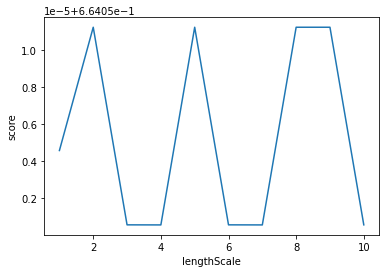

In [52]:
plt.figure()
plt.plot(rbf_kernel_scores[:,0], rbf_kernel_scores[:,1])
plt.xlabel('lengthScale');
plt.ylabel('score');

# Conclusion

RBF kernel looks like a good option. The value of the hyper parameter itself does not seem to make much difference, but there are some things to check yet. In particular, 

```
n_restarts_optimizerint, default=0

    The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.
```

from https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html could be an option.